In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay


In [ ]:
df = pd.read_parquet("discover_cleaned.parquet")

In [ ]:
# Definining the binary outcome variable: 
# 1 if PHQ-9 score decreased by 2 or more points, else 0
df["binary_change"] = df["phq9_change"].apply(lambda x: 1 if x <= -2 else 0)

In [ ]:
# Check distribution of target variable
print(df["binary_change"].value_counts())

binary_change
0    7374
1    3492
Name: count, dtype: int64


In [8]:
df.columns

Index(['steps_awake_mean', 'sleep_asleep_weekday_mean',
       'sleep_asleep_weekend_mean', 'sleep_in_bed_weekday_mean',
       'sleep_in_bed_weekend_mean', 'sleep_ratio_asleep_in_bed_weekday_mean',
       'sleep_ratio_asleep_in_bed_weekend_mean',
       'sleep_main_start_hour_adj_median', 'sleep__hypersomnia_count_',
       'sleep__hyposomnia_count_', 'steps__active_day_count_',
       'steps__sedentary_day_count_', 'steps_mvpa_sum_recent',
       'sleep_asleep_mean_recent', 'sleep_in_bed_mean_recent',
       'sleep_ratio_asleep_in_bed_mean_recent', 'steps_lpa_sum_recent',
       'steps_rolling_6_median_recent', 'steps_rolling_6_max_recent', 'sex',
       'race_white', 'race_black', 'race_hispanic', 'race_asian', 'race_other',
       'birthyear', 'educ', 'height', 'weight', 'bmi', 'pregnant', 'birth',
       'trauma', 'insurance', 'money', 'money_assistance', 'household',
       'comorbid_cancer', 'comorbid_diabetes_typ1', 'comorbid_diabetes_typ2',
       'comorbid_gout', 'comorbid_mi

In [ ]:
# Selected model variables
model_vars = [
    # Activity
    "steps_awake_mean",
    "steps__active_day_count_",
    "steps__sedentary_day_count_",

    # Sleep
    "sleep_asleep_weekday_mean",
    "sleep_asleep_weekend_mean",
    "sleep_in_bed_weekday_mean",
    "sleep_in_bed_weekend_mean",
    "sleep_ratio_asleep_in_bed_weekday_mean",
    "sleep_ratio_asleep_in_bed_weekend_mean",
    "sleep_main_start_hour_adj_median",
    "sleep__hypersomnia_count_",
    "sleep__hyposomnia_count_",

    # Lifestyle
    "life_meditation",
    "life_stress",
    "life_activity_eating",
    "life_red_stop_alcoh",

    # Demographics
    "age", "sex",
    "race_white", "race_black", "race_hispanic", "race_asian", "race_other",
    "educ", "height", "weight", "bmi", "pregnant", "birth",
    "insurance", "money", "money_assistance", "household",

    # Clinical history
    "trauma",
    "has_migraine",
    "comorbid_cancer", "comorbid_diabetes_typ1", "comorbid_diabetes_typ2",
    "comorbid_gout", "comorbid_ms", "comorbid_osteoporosis",
    "comorbid_neuropathic", "comorbid_arthritis"
]

### Clustering

In [ ]:
cluster_vars = model_vars.copy()
# Data needs to be scaled for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[model_vars])

K=2, Silhouette Score=0.1391
K=3, Silhouette Score=0.0792
K=4, Silhouette Score=0.0894
K=5, Silhouette Score=0.0929
K=6, Silhouette Score=0.0907
K=7, Silhouette Score=0.0969
K=8, Silhouette Score=0.0494
K=9, Silhouette Score=0.0569


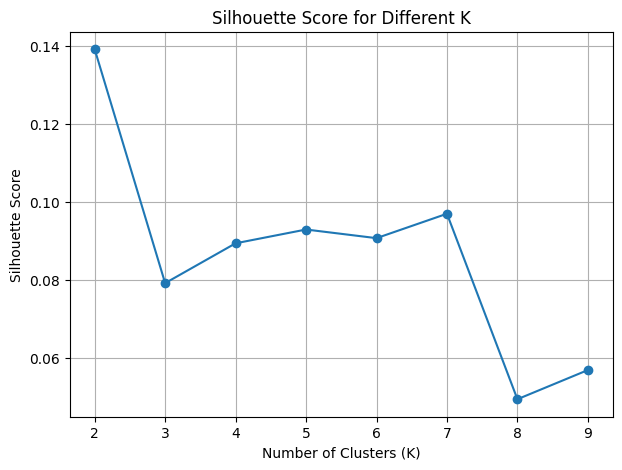

In [ ]:
# Analyze silhouette scores for different K values
sil_scores = []
K_values = range(2, 10)

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)
    print(f"K={k}, Silhouette Score={sil:.4f}")

plt.figure(figsize=(7, 5))
plt.plot(K_values, sil_scores, marker="o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different K")
plt.grid(True)
plt.show()


In [ ]:
# Best K based on silhouette scores
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
df["cluster_kmeans"] = kmeans.fit_predict(X_scaled)

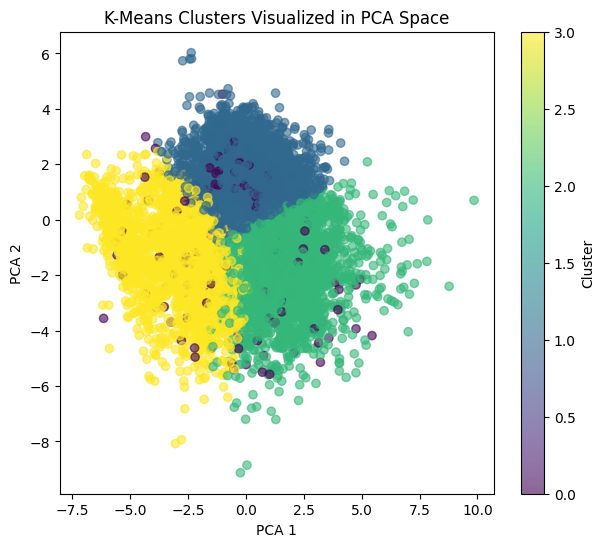

In [ ]:
# Reduction to 2 principal components for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df["pca1"] = X_pca[:, 0]
df["pca2"] = X_pca[:, 1]

plt.figure(figsize=(7, 6))
plt.scatter(df["pca1"], df["pca2"], c=df["cluster_kmeans"], alpha=0.6)
plt.title("K-Means Clusters Visualized in PCA Space")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster")
plt.show()


In [27]:
# Studying clusters
df["cluster"] = df["cluster_kmeans"]
df_cluster = df[cluster_vars + ["cluster"]].copy()

cluster_profiles = df_cluster.groupby("cluster")[cluster_vars].mean()

feature_means = df_cluster[cluster_vars].mean()
feature_stds = df_cluster[cluster_vars].std()

cluster_profiles_z = (cluster_profiles - feature_means) / feature_stds

cluster_profiles, cluster_profiles_z

(         steps_awake_mean  steps__active_day_count_  \
 cluster                                               
 0             8237.158493                  2.068592   
 1            10165.912659                  3.020789   
 2             5586.039132                  0.673733   
 3             8821.097652                  2.192146   
 
          steps__sedentary_day_count_  sleep_asleep_weekday_mean  \
 cluster                                                           
 0                           2.108303                 359.827302   
 1                           0.929548                 410.399029   
 2                           3.486636                 421.976350   
 3                           1.491351                 169.785672   
 
          sleep_asleep_weekend_mean  sleep_in_bed_weekday_mean  \
 cluster                                                         
 0                       374.418773                 414.753508   
 1                       448.099134                 43

In [ ]:
# Summarizing top features per cluster
cluster_top_features = {}

for c in cluster_profiles_z.index:
    sorted_feats = cluster_profiles_z.loc[c].abs().sort_values(ascending=False)
    cluster_top_features[c] = sorted_feats.head(5)

pd.DataFrame(cluster_top_features)


,0,1,2,3
bmi,NaN,NaN,0.575050,NaN
comorbid_neuropathic,0.325056,NaN,NaN,NaN
has_migraine,0.393821,0.402142,0.591304,NaN
race_black,0.460336,NaN,NaN,NaN
race_other,6.182550,NaN,NaN,NaN
race_white,0.989644,NaN,NaN,NaN
sleep__hyposomnia_count_,NaN,0.453082,NaN,1.626213
sleep_asleep_weekday_mean,NaN,NaN,NaN,1.511059
sleep_asleep_weekend_mean,NaN,NaN,NaN,1.320087
sleep_in_bed_weekday_mean,NaN,NaN,NaN,1.095824


In [ ]:
# Mapping cluster labels back to original dataframe
# We are analyzing how clusters relate to PHQ-9 changes
df["cluster"] = df_cluster["cluster"]
display(df["cluster"].value_counts())
df.groupby("cluster")["phq9_change"].mean()


cluster
1    5195
2    3255
3    2139
0     277
Name: count, dtype: int64

cluster
0   -0.093863
1   -0.104139
2   -0.282642
3   -0.291725
Name: phq9_change, dtype: float64

## Predictive Modelling

In [32]:
# Function to evaluate model performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    # roc_auc score
    y_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"ROC AUC Score: {roc_auc:.4f}")
    RocCurveDisplay.from_predictions(y_test, y_proba)
    # title as the model used
    plt.title(f"ROC Curve - {model.__class__.__name__}")
    plt.show()

### Logistic Regression

#### Fitting

In [18]:
X = df[model_vars]
y = df["binary_change"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

#### Evaluation

Accuracy: 0.5662373505059798

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.60      0.65      1475
           1       0.37      0.50      0.43       699

    accuracy                           0.57      2174
   macro avg       0.54      0.55      0.54      2174
weighted avg       0.61      0.57      0.58      2174

Confusion Matrix:
 [[879 596]
 [347 352]]
ROC AUC Score: 0.5775


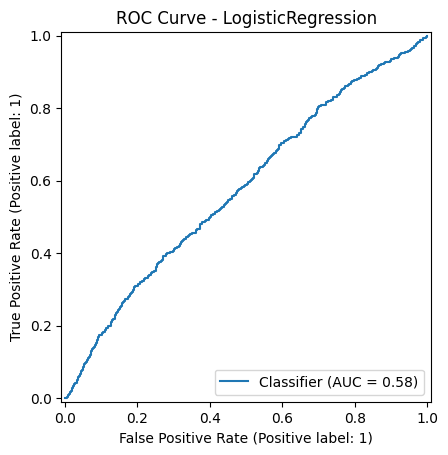

In [33]:
evaluate_model(model, X_test_scaled, y_test)

#### Studying Coefficients

In [20]:
coeffs = pd.DataFrame({
    "feature": X.columns,
    "coef": model.coef_[0]
}).sort_values("coef", ascending=False)

top_positive = coeffs.head(10)
top_negative = coeffs.tail(10)

print(top_positive)
print(top_negative)



                                   feature      coef
6                sleep_in_bed_weekend_mean  0.218404
14                    life_activity_eating  0.183159
8   sleep_ratio_asleep_in_bed_weekend_mean  0.153019
34                            has_migraine  0.119087
41                    comorbid_neuropathic  0.104601
42                      comorbid_arthritis  0.088390
30                                   money  0.086559
26                                     bmi  0.057875
18                              race_white  0.039728
11                sleep__hyposomnia_count_  0.036199
                                   feature      coef
22                              race_other -0.018100
1                 steps__active_day_count_ -0.018411
38                           comorbid_gout -0.022066
27                                pregnant -0.027039
31                        money_assistance -0.048715
25                                  weight -0.051344
7   sleep_ratio_asleep_in_bed_weekday_mean -0.

In [21]:
coeffs["odds_ratio"] = np.exp(coeffs["coef"])
print(coeffs.sort_values("odds_ratio", ascending=False))

                                   feature      coef  odds_ratio
6                sleep_in_bed_weekend_mean  0.218404    1.244089
14                    life_activity_eating  0.183159    1.201005
8   sleep_ratio_asleep_in_bed_weekend_mean  0.153019    1.165347
34                            has_migraine  0.119087    1.126468
41                    comorbid_neuropathic  0.104601    1.110268
42                      comorbid_arthritis  0.088390    1.092414
30                                   money  0.086559    1.090416
26                                     bmi  0.057875    1.059583
18                              race_white  0.039728    1.040527
11                sleep__hyposomnia_count_  0.036199    1.036862
36                  comorbid_diabetes_typ1  0.033519    1.034087
21                              race_asian  0.025951    1.026291
13                             life_stress  0.022751    1.023012
10               sleep__hypersomnia_count_  0.019555    1.019748
39                       

### Random Forest

#### Fitting

Accuracy: 0.6494940202391905

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.93      0.78      1475
           1       0.29      0.06      0.10       699

    accuracy                           0.65      2174
   macro avg       0.48      0.50      0.44      2174
weighted avg       0.55      0.65      0.56      2174

Confusion Matrix:
 [[1368  107]
 [ 655   44]]
ROC AUC Score: 0.5392


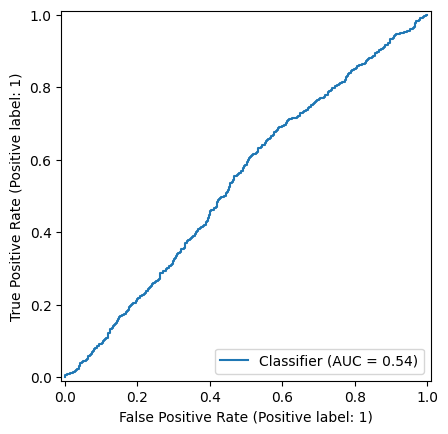

In [ ]:
rf = RandomForestClassifier(
    n_estimators=800,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

#### Evaluation

Accuracy: 0.6494940202391905

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.93      0.78      1475
           1       0.29      0.06      0.10       699

    accuracy                           0.65      2174
   macro avg       0.48      0.50      0.44      2174
weighted avg       0.55      0.65      0.56      2174

Confusion Matrix:
 [[1368  107]
 [ 655   44]]
ROC AUC Score: 0.5392


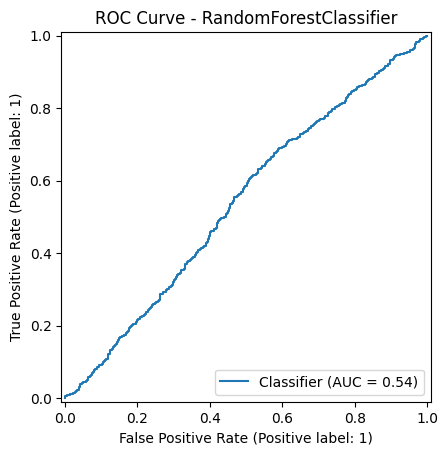

In [34]:
evaluate_model(rf, X_test, y_test)

#### Feature importances

In [35]:
importances = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

print(importances.head(20))

                                   feature  importance
0                         steps_awake_mean    0.073175
7   sleep_ratio_asleep_in_bed_weekday_mean    0.070656
8   sleep_ratio_asleep_in_bed_weekend_mean    0.068864
5                sleep_in_bed_weekday_mean    0.067864
3                sleep_asleep_weekday_mean    0.066720
6                sleep_in_bed_weekend_mean    0.065263
4                sleep_asleep_weekend_mean    0.064905
26                                     bmi    0.063194
25                                  weight    0.057060
16                                     age    0.054103
24                                  height    0.047471
9         sleep_main_start_hour_adj_median    0.038705
32                               household    0.028128
1                 steps__active_day_count_    0.027865
2              steps__sedentary_day_count_    0.027564
11                sleep__hyposomnia_count_    0.023938
23                                    educ    0.023540
30        